### Imports

In [1]:
import cv2
import glob
import os
import sys
import numpy as np
import json
import itertools
from collections import defaultdict

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from data_preprocessing import *

#### Reading

In [4]:
img_dir = 'leftImg8bit'

In [5]:
# paths
cities = get_cities()

mode = 'train'
city = 'zurich'

In [6]:
cities['val']

['munster', 'frankfurt', 'lindau']

## Test

In [108]:
imgs_paths = ReadFilePaths(mode, city, img_dir)
disp_imgs_paths = ReadFilePaths(mode, city, 'disparity')
annos_paths = ReadFilePaths(mode, city, 'gtFine', '.json')
anno_imgs_paths = ReadFilePaths(mode, city, 'gtFine', 'gtFine_color.png')

print disp_imgs_paths[0]

(train, zurich): number of pngs is 122
(train, zurich): number of pngs is 122
(train, zurich): number of pngs is 122
(train, zurich): number of pngs is 122
..\data\cityscapes\disparity\train\zurich\zurich_000000_000019_disparity.png


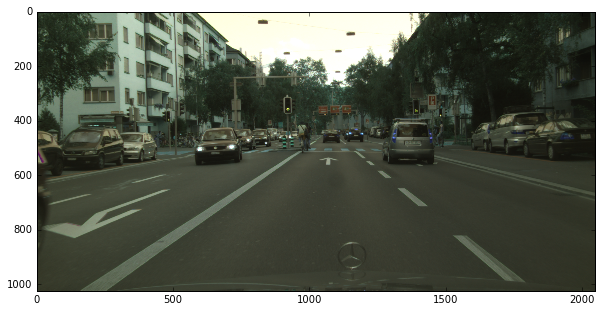

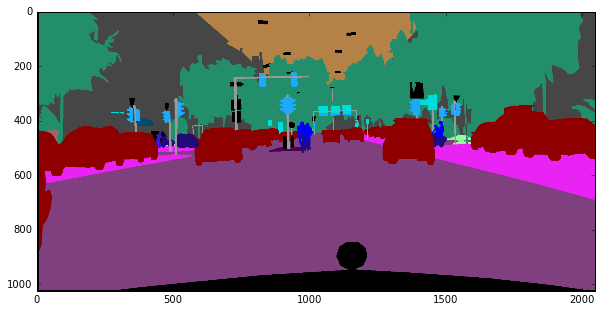

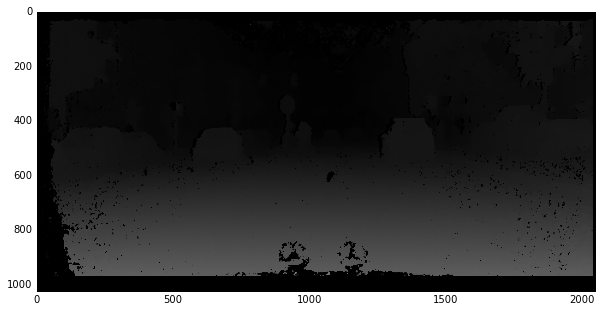

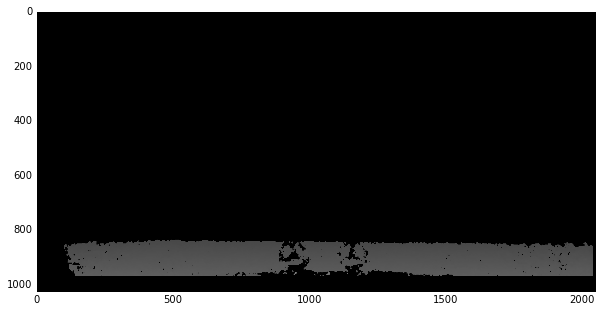

In [109]:
# good example nmb_image = 41, 12
i = np.random.randint(0, len(disp_imgs_paths))

disp = cv2.imread(disp_imgs_paths[i])
img = cv2.imread(imgs_paths[i])
img_path = imgs_paths[i]
anno_img = cv2.imread(anno_imgs_paths[i])

Plot(img)
Plot(anno_img)

''' All disparity'''
Plot(disp)

''' Disparity in percentile '''
disp_perc = disp.copy()
disp_perc[disp < np.percentile(disp, 90)] = 0
Plot(disp_perc)

## Disparities in the percentile

126


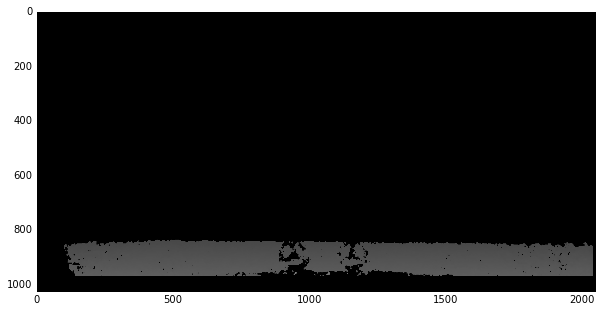

In [110]:
disp_perc = disp.copy()
disp_perc[disp < np.percentile(disp, 90)] = 0
print disp.max()
Plot(disp_perc)

## Image's pixels correspondes to disparity in the percentile

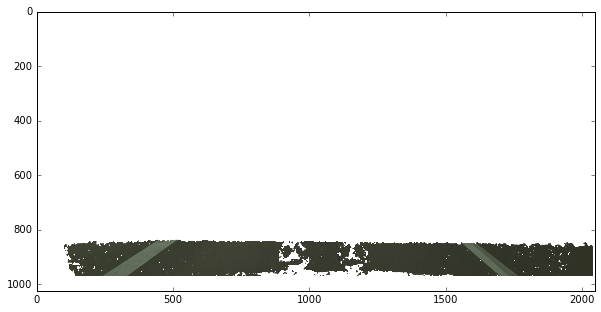

In [111]:
img_perc = img.copy()
img_perc[disp < np.percentile(disp, 90)] = 255
Plot(img_perc)

## RoI, Cropped image

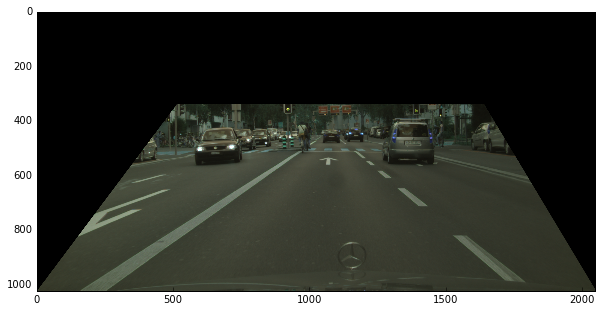

In [112]:
Plot(CropRoI(cv2.imread(img_path, -1)))

## Exluding Road

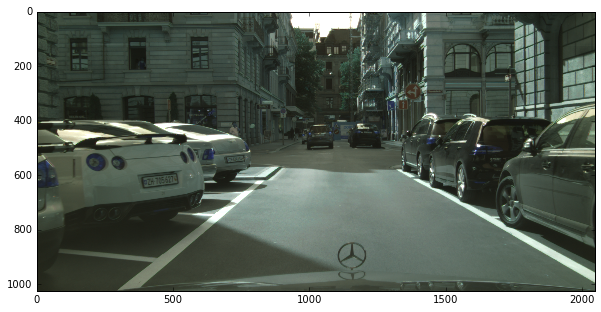

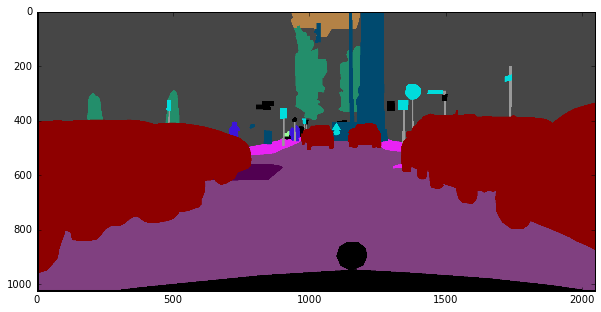

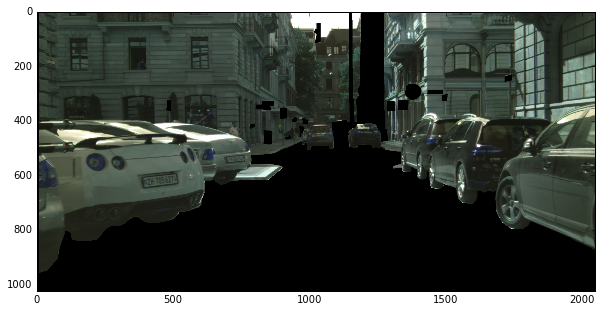

In [14]:
Plot(img)
Plot(anno_img)
masked_img = ExcludeRoadDisp(img, anno_img, [(128, 64, 128), (0, 0, 0)])
Plot(masked_img)

## Histogram of max disparties for this city

122
..\data\cityscapes\disparity\train\zurich\zurich_000000_000019_disparity.png


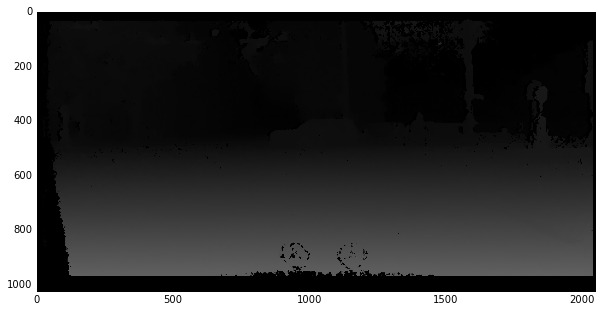

In [82]:
max_disps, max_disps_excl = [], []

print len(disp_imgs_paths)
for disp, anno in zip(disp_imgs_paths, anno_imgs_paths):
    disp = cv2.imread(disp)
    max_disps.append(disp.max())

    anno = cv2.imread(anno)
    excl_img = ExcludeRoadDisp(disp, anno, [(128, 64, 128), (0, 0, 0)])
    max_disps_excl.append(excl_img.max())

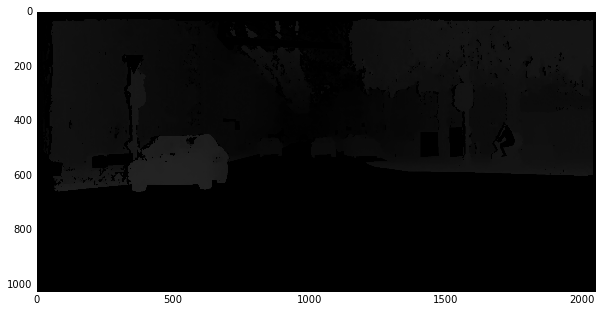

In [33]:
Plot(excl_img)

(array([  4.,   1.,   2.,   1.,   5.,   4.,   1.,   1.,   4.,   1.,   1.,
          2.,   1.,   3.,   1.,   3.,   2.,   8.,  15.,   8.,  12.,  11.,
          9.,   7.,  15.]),
 array([  36. ,   39.6,   43.2,   46.8,   50.4,   54. ,   57.6,   61.2,
          64.8,   68.4,   72. ,   75.6,   79.2,   82.8,   86.4,   90. ,
          93.6,   97.2,  100.8,  104.4,  108. ,  111.6,  115.2,  118.8,
         122.4,  126. ]),
 <a list of 25 Patch objects>)

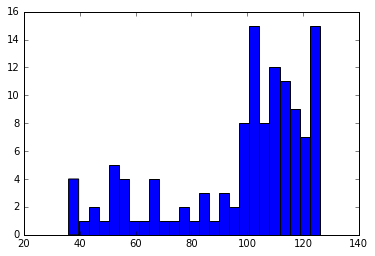

In [34]:
plt.hist(max_disps_excl, bins=25)

(array([  3.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   2.,
          1.,   3.,   1.,   1.,   2.,   4.,   1.,   3.,   2.,   4.,   8.,
          5.,   7.,  71.]),
 array([  98.  ,   99.12,  100.24,  101.36,  102.48,  103.6 ,  104.72,
         105.84,  106.96,  108.08,  109.2 ,  110.32,  111.44,  112.56,
         113.68,  114.8 ,  115.92,  117.04,  118.16,  119.28,  120.4 ,
         121.52,  122.64,  123.76,  124.88,  126.  ]),
 <a list of 25 Patch objects>)

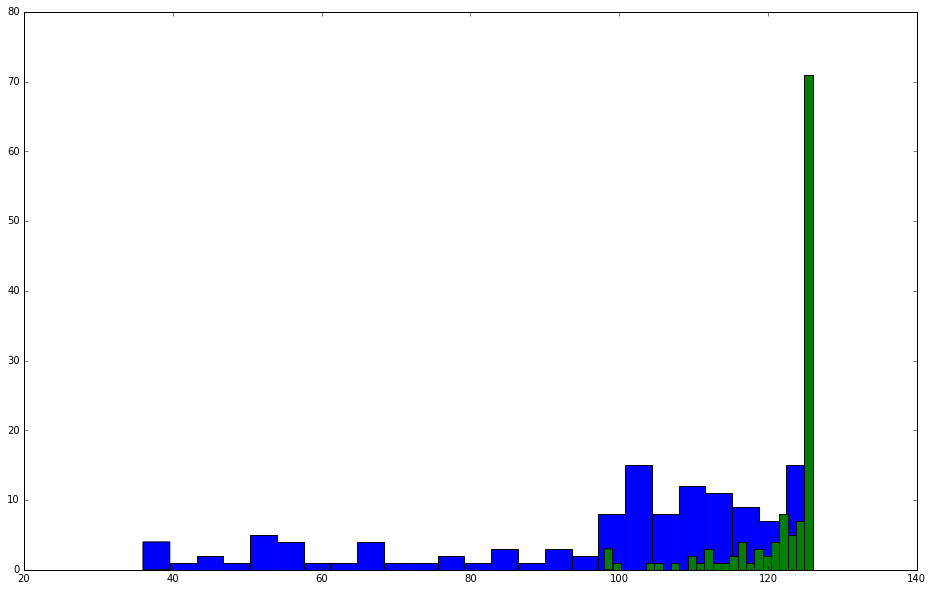

In [39]:
plt.figure(figsize=(16, 10))
plt.hist(max_disps_excl, bins=25)
plt.hist(max_disps, bins=25)

## Get Target Value

In [ ]:
from data_preprocessing import *

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
cities = get_cities()
modes = ['train', 'val']
dataset = prepare_dataset(
        itertools.chain(*[zip(ReadFilePaths(mode, city, 'leftImg8bit'),
                              ReadFilePaths(mode, city, 'gtFine', 'gtFine_color.png'),
                              ReadFilePaths(mode, city, 'disparity'))
                        for mode in modes for city in cities[mode]]))

In [7]:
X, y = dataset.next()
X.shape, y

((1024L, 2048L, 3L), 51)

(array([  4.,   1.,   2.,   1.,   5.,   4.,   1.,   1.,   4.,   1.,   1.,
          2.,   1.,   3.,   1.,   3.,   2.,   8.,  15.,   8.,  12.,  11.,
          9.,   7.,  15.]),
 array([  36. ,   39.6,   43.2,   46.8,   50.4,   54. ,   57.6,   61.2,
          64.8,   68.4,   72. ,   75.6,   79.2,   82.8,   86.4,   90. ,
          93.6,   97.2,  100.8,  104.4,  108. ,  111.6,  115.2,  118.8,
         122.4,  126. ]),
 <a list of 25 Patch objects>)

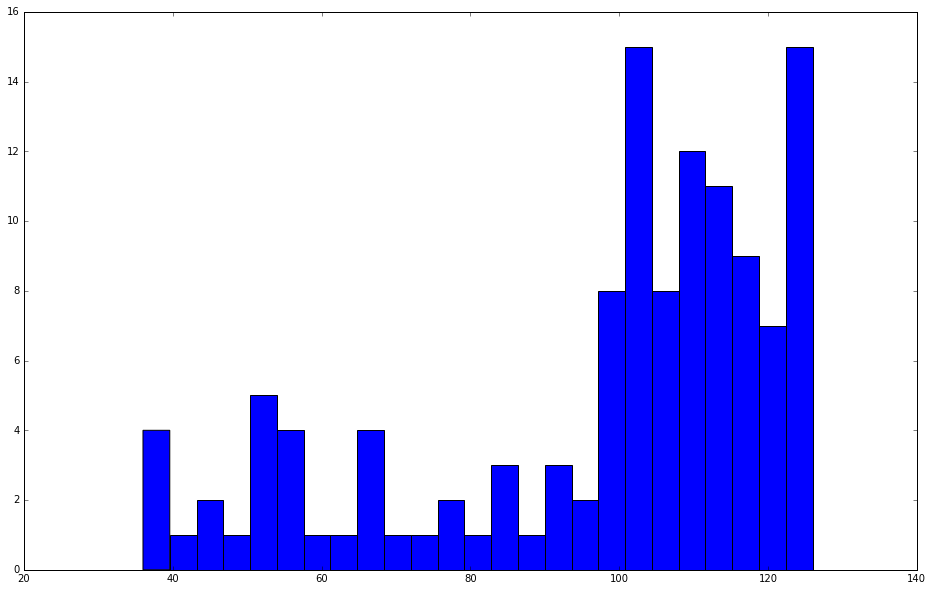

In [103]:
plt.figure(figsize=(16, 10))
plt.hist(list(zip(*dataset))[1], bins=25)

# Prepare the file with segmentations for noise removal

In [9]:
os.path.join('a', '/b')

'/b'